In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt   
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor,plot_importance, plot_tree
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from prophet import Prophet


import warnings
warnings.filterwarnings('ignore')

c:\Users\Krioha\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Data Preprocesing

**Penjelasan Varibel dataframe** \
dfp= Dataframe Product \
dfc= Dataframe Customer \
dfs= Dataframe Store \
dft= Dataframe Transaction 

In [2]:
dfc=pd.read_csv("D:\Pelatihan\PBA\Kalbe DS\Portofolio\Case Study Data Scientist\Case Study - Customer.csv", sep=';')
dfp=pd.read_csv("D:\Pelatihan\PBA\Kalbe DS\Portofolio\Case Study Data Scientist\Case Study - Product.csv", sep=';' )
dft=pd.read_csv("D:\Pelatihan\PBA\Kalbe DS\Portofolio\Case Study Data Scientist\Case Study - Transaction.csv", sep=';')
dfs=pd.read_csv("D:\Pelatihan\PBA\Kalbe DS\Portofolio\Case Study Data Scientist\Case Study - Store.csv", sep=';')

In [3]:
print(dfc.head())
print(dfc.info())
print(dfc.describe())

   CustomerID  Age  Gender Marital Status Income
0           1   55       1        Married   5,12
1           2   60       1        Married   6,23
2           3   32       1        Married   9,17
3           4   31       1        Married   4,87
4           5   58       1        Married   3,57
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      447 non-null    int64 
 1   Age             447 non-null    int64 
 2   Gender          447 non-null    int64 
 3   Marital Status  444 non-null    object
 4   Income          447 non-null    object
dtypes: int64(3), object(2)
memory usage: 17.6+ KB
None
       CustomerID         Age      Gender
count  447.000000  447.000000  447.000000
mean   224.000000   39.782998    0.458613
std    129.182042   12.848719    0.498842
min      1.000000    0.000000    0.000000
25%    112.500000   30.00000

**Fitur yang akan digunakan pada table customer**
- Fitur customerID sebagai foreign key untuk table transaksi untuk mengetahui siapa customer yang membeli
- Fitur Income Akan dilakukan aggregration rata rata agar mengetahui berapa rata rata pendapatan pembeli untuk jumlah barang yang terjual pada hari tersebut kemungkinan nilainya akan berkorelasi
- usia akan saya coba masukan dan nanti di akhir akan saya check korelasinya secara keseluruhan
- Fitur berupa kategorikal akan sulit berkorelasi apabila melakukan grouping jadi tidak saya gunakan


In [4]:
dfc.drop(['Gender','Marital Status'] , axis=1, inplace=True)

In [5]:
dfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   CustomerID  447 non-null    int64 
 1   Age         447 non-null    int64 
 2   Income      447 non-null    object
dtypes: int64(2), object(1)
memory usage: 10.6+ KB


In [6]:
#ubah income menjadi integer
dfc['Income']=dfc['Income'].str.replace(',', '')
dfc['Income']=dfc['Income'].astype('int64')

#menambah jumlah 0 sebanyak 4 digit di belakang angka
dfc['Income']=dfc['Income']*10000

In [7]:
dfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   CustomerID  447 non-null    int64
 1   Age         447 non-null    int64
 2   Income      447 non-null    int64
dtypes: int64(3)
memory usage: 10.6 KB


In [8]:
dfc.head()

,CustomerID,Age,Income
0,1,55,5120000
1,2,60,6230000
2,3,32,9170000
3,4,31,4870000
4,5,58,3570000


In [9]:
print(dfp.head())
print(dfp.info())
print(dfp.describe())

  ProductID   Product Name  Price
0        P1      Choco Bar   8800
1        P2  Ginger Candy    3200
2        P3       Crackers   7500
3        P4    Potato Chip  12000
4        P5       Thai Tea   4200
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ProductID     10 non-null     object
 1   Product Name  10 non-null     object
 2   Price         10 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 368.0+ bytes
None
              Price
count     10.000000
mean   10410.000000
std     4890.455557
min     3200.000000
25%     7825.000000
50%     9700.000000
75%    14250.000000
max    18000.000000


**Fitur yang akan digunakan pada table product**
- Fitur ProductID sebagai foreign key untuk table transaksi untuk mengetahui barang apa yang dibeli
- Fitur Price Akan dilakukan aggregration rata rata atau penjumlahan agar mengetahui berapa rata rata atau penjumlahan harga barang untuk jumlah barang yang terjual pada hari tersebut kemungkinan nilainya akan berkorelasi
- Fitur Product Name tidak akan digunakan karna berupa categorical yang sulit berkorelasi apabila dilakukan grouping

In [10]:
dfp.drop(['Product Name'] , axis=1, inplace=True)

In [11]:
dfp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ProductID  10 non-null     object
 1   Price      10 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 288.0+ bytes


In [12]:
print(dfs.head())
print(dfs.info())
print(dfs.describe())

   StoreID         StoreName GroupStore           Type   Latitude   Longitude
0        1     Prima Tendean      Prima   Modern Trade       -6,2  106,816666
1        2  Prima Kelapa Dua      Prima   Modern Trade  -6,914864  107,608238
2        3        Prima Kota      Prima   Modern Trade  -7,797068  110,370529
3        4       Gita Ginara       Gita  General Trade  -6,966667  110,416664
4        5           Bonafid       Gita  General Trade  -7,250445  112,768845
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   StoreID     14 non-null     int64 
 1   StoreName   14 non-null     object
 2   GroupStore  14 non-null     object
 3   Type        14 non-null     object
 4   Latitude    14 non-null     object
 5   Longitude   14 non-null     object
dtypes: int64(1), object(5)
memory usage: 800.0+ bytes
None
       StoreID
count  14.0000
mean    7.5000
std  

**Fitur yang akan digunakan pada table store**
- Tidak ada fitur yang akan digunakan pada table store karna hanya mengandung nama tempat, grup store, tipe, dan lokasi secara latitude,longitude yang membuat \
tidak ada fitur yang berkorelasi dengan jumlah barang yang terjual per hari

In [13]:
print(dft.head())
print(dft.info())
print(dft.describe())

  TransactionID  CustomerID        Date ProductID  Price  Qty  TotalAmount  \
0       TR11369         328  01/01/2022        P3   7500    4        30000   
1       TR16356         165  01/01/2022        P9  10000    7        70000   
2        TR1984         183  01/01/2022        P1   8800    4        35200   
3       TR35256         160  01/01/2022        P1   8800    7        61600   
4       TR41231         386  01/01/2022        P9  10000    1        10000   

   StoreID  
0       12  
1        1  
2        4  
3        4  
4        4  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TransactionID  5020 non-null   object
 1   CustomerID     5020 non-null   int64 
 2   Date           5020 non-null   object
 3   ProductID      5020 non-null   object
 4   Price          5020 non-null   int64 
 5   Qty            5020 non-null   int64 
 6 

In [14]:
dft.drop(['StoreID'], axis=1, inplace=True)

In [15]:
dft.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount
0,TR11369,328,01/01/2022,P3,7500,4,30000
1,TR16356,165,01/01/2022,P9,10000,7,70000
2,TR1984,183,01/01/2022,P1,8800,4,35200
3,TR35256,160,01/01/2022,P1,8800,7,61600
4,TR41231,386,01/01/2022,P9,10000,1,10000


In [16]:
#rubah tipe data tanggal menjadi datetime
dft['Date']=pd.to_datetime(dft['Date'], format='%d/%m/%Y')

#menggabungkan data
df=pd.merge(dft,dfc, on='CustomerID', how='left')
df=pd.merge(df,dfp, on='ProductID', how='left')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5020 entries, 0 to 5019
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   TransactionID  5020 non-null   object        
 1   CustomerID     5020 non-null   int64         
 2   Date           5020 non-null   datetime64[ns]
 3   ProductID      5020 non-null   object        
 4   Price_x        5020 non-null   int64         
 5   Qty            5020 non-null   int64         
 6   TotalAmount    5020 non-null   int64         
 7   Age            5020 non-null   int64         
 8   Income         5020 non-null   int64         
 9   Price_y        5020 non-null   int64         
dtypes: datetime64[ns](1), int64(7), object(2)
memory usage: 431.4+ KB


In [18]:
#hapus kolom yang tidak diperlukan
df.drop(['Price_y'], axis=1, inplace=True)
#ubah nama kolom Price_x menjadi Price
df.rename(columns={'Price_x':'Price'}, inplace=True)    

In [19]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5020 entries, 0 to 5019
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   TransactionID  5020 non-null   object        
 1   CustomerID     5020 non-null   int64         
 2   Date           5020 non-null   datetime64[ns]
 3   ProductID      5020 non-null   object        
 4   Price          5020 non-null   int64         
 5   Qty            5020 non-null   int64         
 6   TotalAmount    5020 non-null   int64         
 7   Age            5020 non-null   int64         
 8   Income         5020 non-null   int64         
dtypes: datetime64[ns](1), int64(6), object(2)
memory usage: 392.2+ KB


,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,Age,Income
0,TR11369,328,2022-01-01,P3,7500,4,30000,36,10530000
1,TR16356,165,2022-01-01,P9,10000,7,70000,44,14580000
2,TR1984,183,2022-01-01,P1,8800,4,35200,27,180000
3,TR35256,160,2022-01-01,P1,8800,7,61600,48,12570000
4,TR41231,386,2022-01-01,P9,10000,1,10000,33,6950000


# Prophet Time Series

In [20]:
daily_qty = df.groupby('Date')['Qty'].sum()
daily_qty = daily_qty.sort_index()

In [21]:
train_size = int(0.8 * len(daily_qty))
train_data = daily_qty[:train_size]
test_data = daily_qty[train_size:]

In [22]:
train_data.reset_index() \
    .rename(columns={'Date':'ds',
                     'Qty':'y'}).head()


,ds,y
0,2022-01-01,49
1,2022-01-02,59
2,2022-01-03,63
3,2022-01-04,45
4,2022-01-05,30


In [23]:
model = Prophet()
model.fit(train_data.reset_index() \
              .rename(columns={'Date':'ds',
                               'Qty':'y'}))

22:37:53 - cmdstanpy - INFO - Chain [1] start processing
22:37:53 - cmdstanpy - INFO - Chain [1] done processing


In [24]:
test_results=model.predict(df=test_data.reset_index() \
                                   .rename(columns={'Date':'ds'}))

In [25]:
test_results.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-10-20,47.884765,26.736705,69.226901,47.884765,47.884765,0.938772,0.938772,0.938772,0.938772,0.938772,0.938772,0.0,0.0,0.0,48.823537
1,2022-10-21,47.863673,27.129473,70.792890,47.863673,47.863673,0.984634,0.984634,0.984634,0.984634,0.984634,0.984634,0.0,0.0,0.0,48.848307
2,2022-10-22,47.842580,26.373177,70.026219,47.842580,47.842581,0.024790,0.024790,0.024790,0.024790,0.024790,0.024790,0.0,0.0,0.0,47.867371
3,2022-10-23,47.821488,24.865088,68.666771,47.821486,47.821490,-1.477412,-1.477412,-1.477412,-1.477412,-1.477412,-1.477412,0.0,0.0,0.0,46.344076
4,2022-10-24,47.800395,26.805144,70.111305,47.800392,47.800399,-0.337060,-0.337060,-0.337060,-0.337060,-0.337060,-0.337060,0.0,0.0,0.0,47.463335


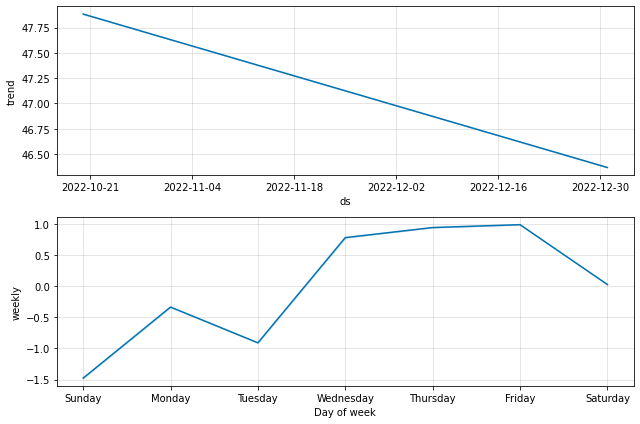

In [26]:
fig = model.plot_components(test_results)

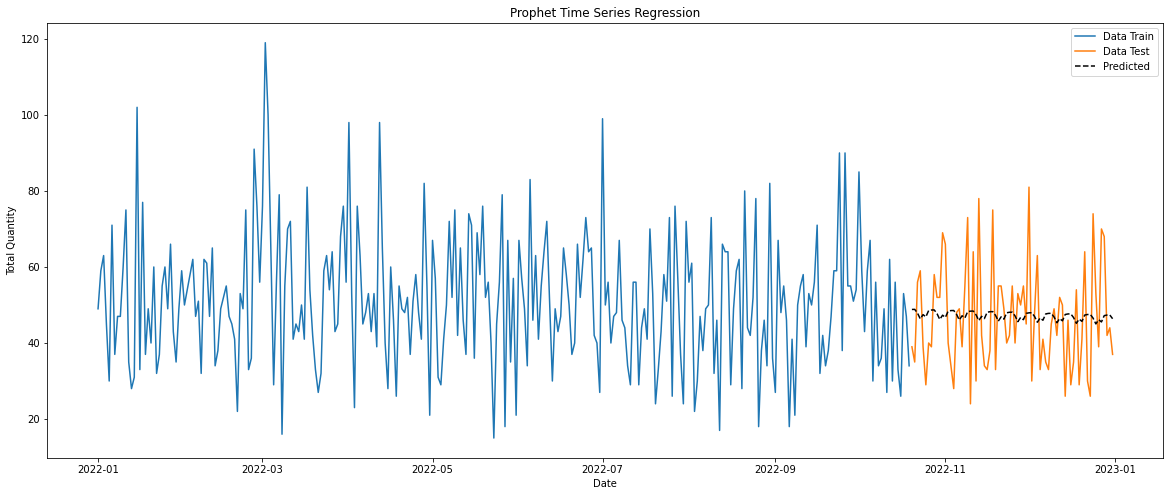

In [27]:
# Menampilkan hasil prediksi
plt.figure(figsize=(20,8))
plt.plot(train_data.index, train_data.values, label='Data Train')
plt.plot(test_data.index, test_data.values, label='Data Test')
plt.plot(test_data.index, test_results['yhat'], label='Predicted',linestyle='dashed', color='black')
plt.xlabel('Date')
plt.ylabel('Total Quantity')
plt.title('Prophet Time Series Regression')
plt.legend()
plt.show()

In [28]:
print('MAE:', mean_absolute_error(test_data.values, test_results['yhat']))
print('RMSE:', sqrt(mean_squared_error(test_data.values, test_results['yhat'])))
print('MAPE:', mean_absolute_percentage_error(test_data.values, test_results['yhat']))

MAE: 11.79236073090873
RMSE: 14.061916924064178
MAPE: 0.27852109168193323


# Xgboost Time Series

In [29]:
dff=pd.DataFrame()
dff['date']=daily_qty.index
dff['dayofweek'] = daily_qty.index.dayofweek
dff['month'] = daily_qty.index.month
dff['dayofyear'] = daily_qty.index.dayofyear
dff['dayofmonth'] = daily_qty.index.day

dff['qty']=daily_qty.values

In [30]:
dff.head()

,date,dayofweek,month,dayofyear,dayofmonth,qty
0,2022-01-01,5,1,1,1,49
1,2022-01-02,6,1,2,2,59
2,2022-01-03,0,1,3,3,63
3,2022-01-04,1,1,4,4,45
4,2022-01-05,2,1,5,5,30


In [31]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        365 non-null    datetime64[ns]
 1   dayofweek   365 non-null    int64         
 2   month       365 non-null    int64         
 3   dayofyear   365 non-null    int64         
 4   dayofmonth  365 non-null    int64         
 5   qty         365 non-null    int64         
dtypes: datetime64[ns](1), int64(5)
memory usage: 17.2 KB


In [32]:
train_size = int(0.8 * len(daily_qty))
train_data = dff[:train_size]
test_data = dff[train_size:]

In [33]:
X_train = train_data.drop(['qty','date'], axis=1)
y_train = train_data['qty']
X_test = test_data.drop(['qty','date'], axis=1)
y_test = test_data['qty']

In [34]:
reg = XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

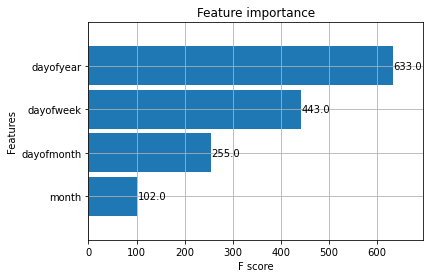

In [35]:
_ = plot_importance(reg, height=0.9)

In [36]:
y_pred = reg.predict(X_test)

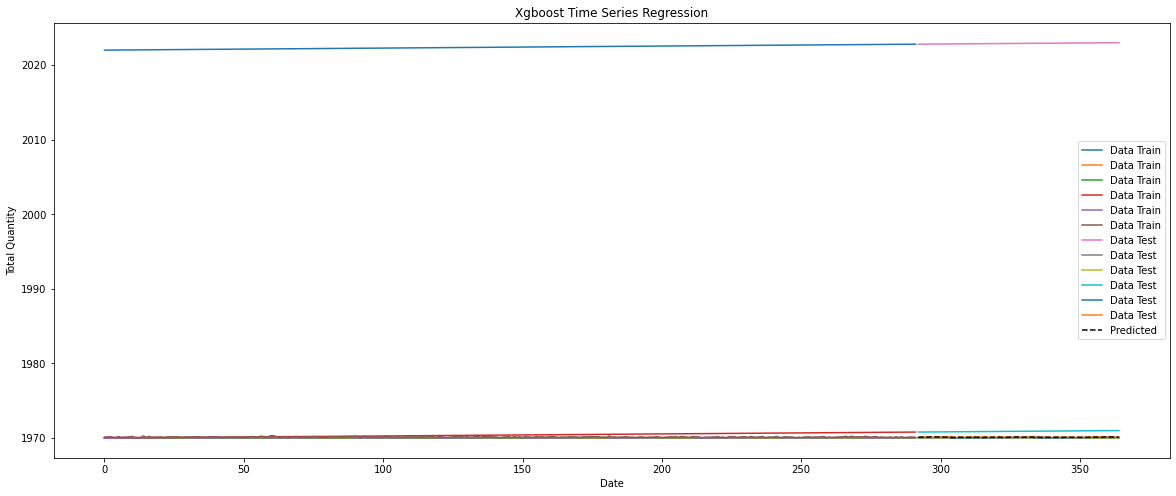

In [37]:
# Menampilkan hasil prediksi
plt.figure(figsize=(20,8))
plt.plot(train_data.index, train_data.values, label='Data Train')
plt.plot(test_data.index, test_data.values, label='Data Test')
plt.plot(test_data.index, y_pred, label='Predicted',linestyle='dashed', color='black')
plt.xlabel('Date')
plt.ylabel('Total Quantity')
plt.title('Xgboost Time Series Regression')
plt.legend()
plt.show()

In [38]:
print('MAE:', mean_absolute_error(y_test, y_pred))
print('RMSE:', sqrt(mean_squared_error(y_test, y_pred)))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MAE: 14.446610725089295
RMSE: 18.43013646377328
MAPE: 0.29923557468401335


# Time Series forcasting

In [39]:
daily_qty = df.groupby('Date')['Qty'].sum()
daily_qty = daily_qty.sort_index()
daily_qty.index.freq = 'D'
train_size = int(0.8 * len(daily_qty))
train_data = daily_qty[:train_size]
test_data = daily_qty[train_size:]


In [40]:
def plot_decompose(decompose_result):
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(12,20))
    decompose_result.observed.plot(legend=False,ax=ax1,fontsize = 20,grid=True,linewidth = 3)
    ax1.set_ylabel("Observed",fontsize = 20)
    decompose_result.trend.plot(legend=False,ax=ax2,fontsize = 20,grid=True,linewidth = 3)
    ax2.set_ylabel("Trend",fontsize = 20)
    decompose_result.seasonal.plot(legend=False,ax=ax3,fontsize = 20,grid=True,linewidth = 3)
    ax3.set_ylabel("Seasonal",fontsize = 20)
    decompose_result.resid.plot(legend=False,ax=ax4,fontsize = 20,grid=True,linewidth = 3)
    ax4.set_ylabel("Residual",fontsize = 20)

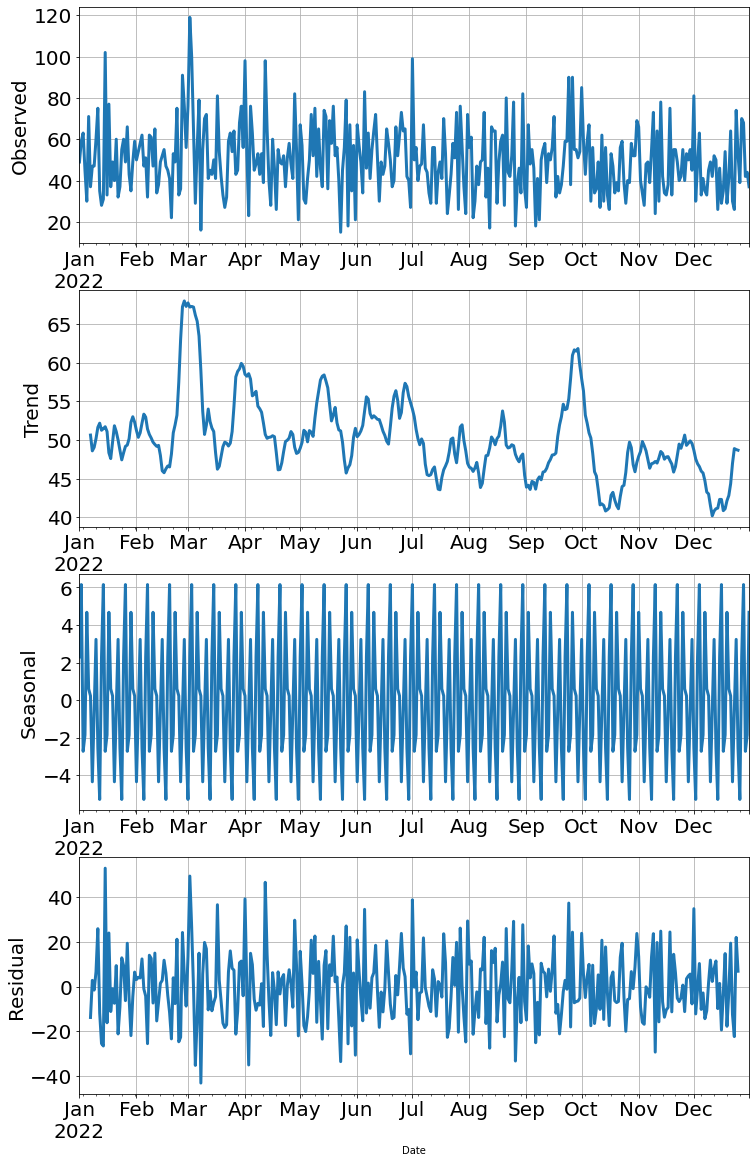

In [41]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(daily_qty, period=12) 
plot_decompose(decomposition)

In [42]:
from pmdarima import auto_arima
# Membuat model ARIMA
stepwise_fit=auto_arima(daily_qty,trace=True,suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3346.981, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3240.037, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3344.981, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3200.778, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3159.485, Time=0.11 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=3152.157, Time=0.20 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=3138.269, Time=0.17 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=3136.272, Time=0.11 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=3150.161, Time=0.08 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=3095.375, Time=0.27 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=3093.741, T

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(4, 1, 1)   Log Likelihood               -1540.871
Date:                Sun, 12 Nov 2023   AIC                           3093.741
Time:                        22:38:01   BIC                           3117.124
Sample:                    01-01-2022   HQIC                          3103.035
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0347      0.048     -0.726      0.468      -0.128       0.059
ar.L2         -0.0180      0.052     -0.344      0.731      -0.120       0.084
ar.L3         -0.0300      0.051     -0.586      0.558      -0.130       0.070
ar.L4          0.0882      0.051      1.728      0.084      -0.012       0.188
ma.L1         -0.9861      0.013    -78.424      0.000      -1.011      -0.961
sigma2       275.4756     20.047     13.741      0.000     236.183     314.768
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                21.90
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                             0.54
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(20,8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:') 
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


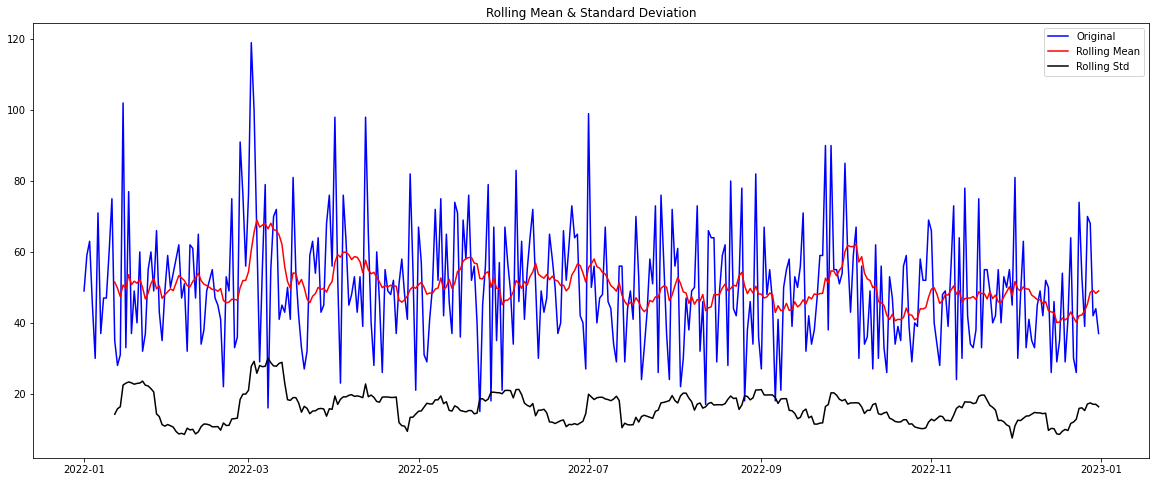

Results of Dickey-Fuller Test:
Test Statistic                 -19.448086
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    364.000000
Critical Value (1%)             -3.448443
Critical Value (5%)             -2.869513
Critical Value (10%)            -2.571018
dtype: float64


In [44]:
test_stationarity(daily_qty)

In [45]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from mango import scheduler, Tuner

def arima_objective_function(args_list):
    global data_values
    
    params_evaluated = []
    results = []
    
    for params in args_list:
        try:
            p,d,q = params['p'],params['d'], params['q']
            
            model = ARIMA(data_values, order=(p,d,q))
            predictions = model.fit()
            mse = mean_squared_error(data_values, predictions.fittedvalues)   
            params_evaluated.append(params)
            results.append(mse)
        except:
            #print(f"Exception raised for {params}")
            #pass 
            params_evaluated.append(params)
            results.append(1e5)
        
        #print(params_evaluated, mse)
    return params_evaluated, results

param_space = dict(p= range(0, 15),
                   d= range(0, 5),
                   q =range(0, 5)
                  )

conf_Dict = dict()
conf_Dict['num_iteration'] = 200
data_values = daily_qty
tuner = Tuner(param_space, arima_objective_function, conf_Dict)
results = tuner.minimize()

  0%|          | 0/200 [00:00<?, ?it/s]

In [46]:
print('best parameters:', results['best_params'])
print('best loss:', results['best_objective'])


best parameters: {'d': 0, 'p': 13, 'q': 2}
best loss: 257.3847934777881


In [47]:
from statsmodels.tsa.arima.model import ARIMA

# Membuat model ARIMA
order = (13,0,2)  # Nilai ini didapat dari pengujian autoarima terbaik
model = ARIMA(train_data, order=order)
model_fit = model.fit()

# Melakukan prediksi pada data uji
predictionGS = model_fit.forecast(steps=len(test_data))

order = (4,1,1)  # Nilai ini didapat dari pengujian autoarima terbaik
model = ARIMA(train_data, order=order)
model_fit = model.fit()

predictionAA = model_fit.forecast(steps=len(test_data))

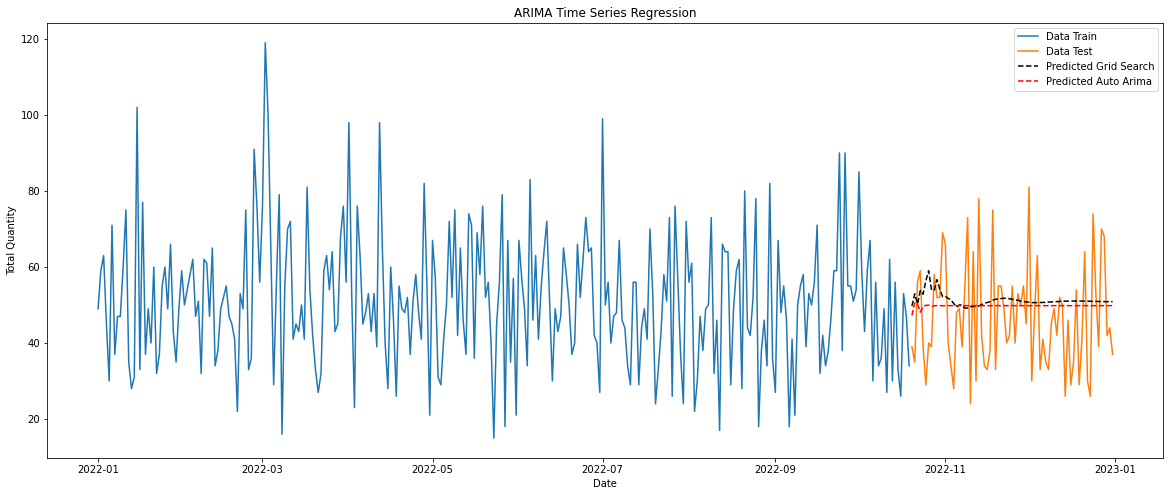

In [48]:
# Menampilkan hasil prediksi
plt.figure(figsize=(20,8))
plt.plot(train_data.index, train_data.values, label='Data Train')
plt.plot(test_data.index, test_data.values, label='Data Test')
plt.plot(test_data.index, predictionGS, label='Predicted Grid Search',linestyle='dashed', color='black')
plt.plot(test_data.index, predictionAA, label='Predicted Auto Arima',linestyle='dashed', color='red')

plt.xlabel('Date')
plt.ylabel('Total Quantity')
plt.title('ARIMA Time Series Regression')
plt.legend()
plt.show()

In [49]:
import pandas as pd

# create a pandas table with dates from January 1 to January 31, 2023
date_table = pd.date_range(start='2023-01-01', end='2023-01-31', freq='D')

# print the date table
print(date_table)


DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04',
               '2023-01-05', '2023-01-06', '2023-01-07', '2023-01-08',
               '2023-01-09', '2023-01-10', '2023-01-11', '2023-01-12',
               '2023-01-13', '2023-01-14', '2023-01-15', '2023-01-16',
               '2023-01-17', '2023-01-18', '2023-01-19', '2023-01-20',
               '2023-01-21', '2023-01-22', '2023-01-23', '2023-01-24',
               '2023-01-25', '2023-01-26', '2023-01-27', '2023-01-28',
               '2023-01-29', '2023-01-30', '2023-01-31'],
              dtype='datetime64[ns]', freq='D')


In [50]:
order = (13,0,2)  # Nilai ini didapat dari pengujian autoarima terbaik
model = ARIMA(train_data, order=order)
model_fit = model.fit()
PredictionJan=model_fit.forecast(steps=len(date_table))

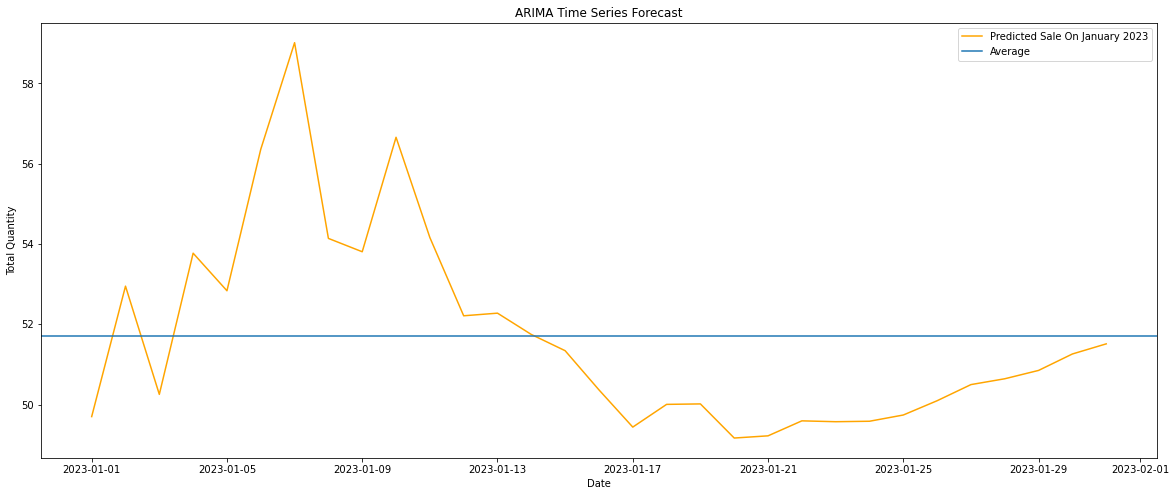

In [51]:
plt.figure(figsize=(20,8))
plt.plot(date_table, PredictionJan, label='Predicted Sale On January 2023', color='orange')
plt.axhline(y=np.nanmean(PredictionJan),label='Average')
plt.xlabel('Date')
plt.ylabel('Total Quantity')
plt.title('ARIMA Time Series Forecast')
plt.legend()
plt.show()
#print average monthly sales

In [52]:
print('MAE Grid Search:', mean_absolute_error(test_data.values, predictionGS))
print('RMSE Grid Search:', sqrt(mean_squared_error(test_data.values,  predictionGS)))
print('MAPE Grid Search:', mean_absolute_percentage_error(test_data.values,  predictionGS))

print('MAE Auto Arima:', mean_absolute_error(test_data.values, predictionAA))
print('RMSE Auto Arima:', sqrt(mean_squared_error(test_data.values,  predictionAA)))
print('MAPE Auto Arima:', mean_absolute_percentage_error(test_data.values,  predictionAA))

MAE Grid Search: 12.396126736937338
RMSE Grid Search: 14.75437185900377
MAPE Grid Search: 0.31271254682976873
MAE Auto Arima: 11.865462506649635
RMSE Auto Arima: 14.17528643226392
MAPE Auto Arima: 0.29395397799625195


# Random Forest Regression

In [53]:
aggregation = {
    'Qty': 'sum',
    'Price': 'sum',
    'TotalAmount': 'sum',
    'Income': 'mean',
    'Age': 'mean'  
}
time_series_data=df.groupby('Date').agg(aggregation).reset_index()
time_series_data.index.freq = 'D'
time_series_data.head()

,Date,Qty,Price,TotalAmount,Income,Age
0,2022-01-01,49,124300,431200,7.730769e+06,38.000000
1,2022-01-02,59,185200,613600,8.181250e+06,40.125000
2,2022-01-03,63,179300,561300,8.443889e+06,37.944444
3,2022-01-04,45,179900,396500,7.499444e+06,41.555556
4,2022-01-05,30,100600,273400,8.010000e+06,33.800000


In [54]:
#membulatkan umur dan icome menjadi integer
time_series_data['Age']=time_series_data['Age'].astype('int64')
time_series_data['Income']=time_series_data['Income'].astype('int64')

In [55]:
time_series_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         365 non-null    datetime64[ns]
 1   Qty          365 non-null    int64         
 2   Price        365 non-null    int64         
 3   TotalAmount  365 non-null    int64         
 4   Income       365 non-null    int64         
 5   Age          365 non-null    int64         
dtypes: datetime64[ns](1), int64(5)
memory usage: 17.2 KB


In [56]:
time_series_data.head()

,Date,Qty,Price,TotalAmount,Income,Age
0,2022-01-01,49,124300,431200,7730769,38
1,2022-01-02,59,185200,613600,8181250,40
2,2022-01-03,63,179300,561300,8443888,37
3,2022-01-04,45,179900,396500,7499444,41
4,2022-01-05,30,100600,273400,8010000,33


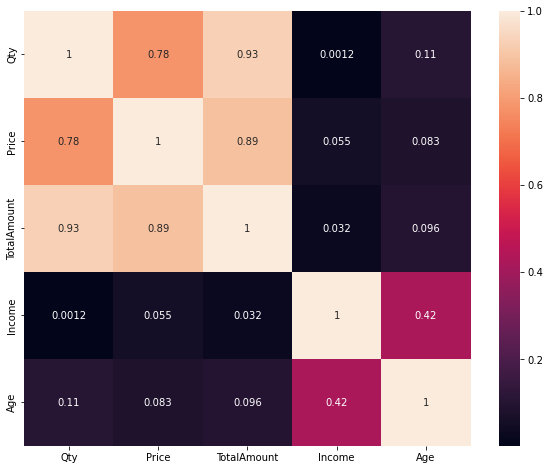

In [57]:
#melihat korelasi antar variabel
plt.figure(figsize=(10,8))
sns.heatmap(time_series_data.corr(), annot=True)
plt.show()

**Hasil Korelasi** \
Berdasarkan Heatmap korelasi diatas variabel Quantity berkorelasi kuat positif terhadap harga dan jumlah amount \
Serta memiliki korelasi lemah terhadap umur dan hampir tidak memiliki korelasi terhadap pendapatan \
jadi saya akan mencoba 2x pengetesan algoritma arima mengikutkan fitur umur dan tidak mengikutkan fitur umur

In [58]:
time_series_data.drop(['Income'], axis=1, inplace=True)

In [59]:
time_series_data['Day']=time_series_data.index

In [60]:
time_series_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         365 non-null    datetime64[ns]
 1   Qty          365 non-null    int64         
 2   Price        365 non-null    int64         
 3   TotalAmount  365 non-null    int64         
 4   Age          365 non-null    int64         
 5   Day          365 non-null    int64         
dtypes: datetime64[ns](1), int64(5)
memory usage: 17.2 KB


In [61]:
train_size = int(0.8 * len(time_series_data))
train = time_series_data[:train_size]
test = time_series_data[train_size:]

In [62]:
X_train = train.drop(['Qty','Date'], axis=1)
y_train = train['Qty']
X_test = test.drop(['Qty','Date'], axis=1)
y_test = test['Qty']

rf = RandomForestRegressor(n_estimators=1000, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print('MAE:', mean_absolute_error(y_test, y_pred))
print('RMSE:', sqrt(mean_squared_error(y_test, y_pred)))

MAE: 4.191191780821918
RMSE: 5.521362767308373


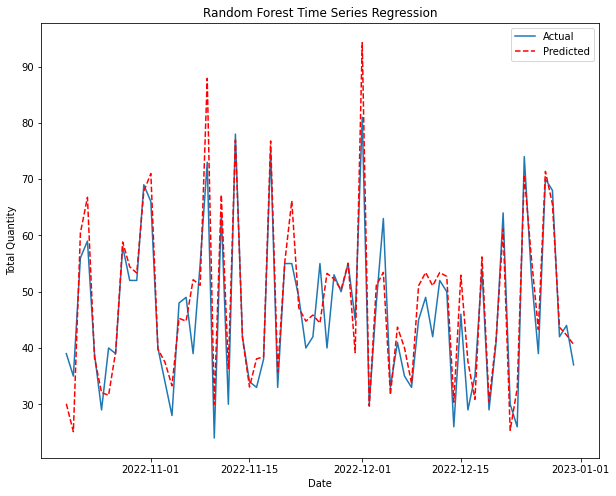

In [63]:
# Menampilkan hasil prediksi
plt.figure(figsize=(10,8))
plt.plot(test_data.index, y_test, label='Actual')
plt.plot(test_data.index, y_pred, label='Predicted',linestyle='dashed', color='red')
plt.xlabel('Date')
plt.ylabel('Total Quantity')
plt.title('Random Forest Time Series Regression')
plt.legend()
plt.show()

# Clustering with KNN Clustering

In [64]:
aggregation = {
    'TransactionID': 'count',
    'Qty': 'sum',
    'TotalAmount': 'sum'
}
cluster_data = df.groupby('CustomerID').agg(aggregation).reset_index()
cluster_data.head()

,CustomerID,TransactionID,Qty,TotalAmount
0,1,17,60,623300
1,2,13,57,392300
2,3,15,56,446200
3,4,10,46,302500
4,5,7,27,268600


In [65]:
cluster_data.drop(['CustomerID'], axis=1, inplace=True)

In [66]:
scaler=StandardScaler()
X=scaler.fit_transform(cluster_data)

In [67]:
wcss=[]
for n in range(1,11):
    kmeans=KMeans(n_clusters=n, init='k-means++', n_init=10, max_iter=300, random_state=100)
    kmeans.fit(cluster_data)
    wcss.append(kmeans.inertia_)

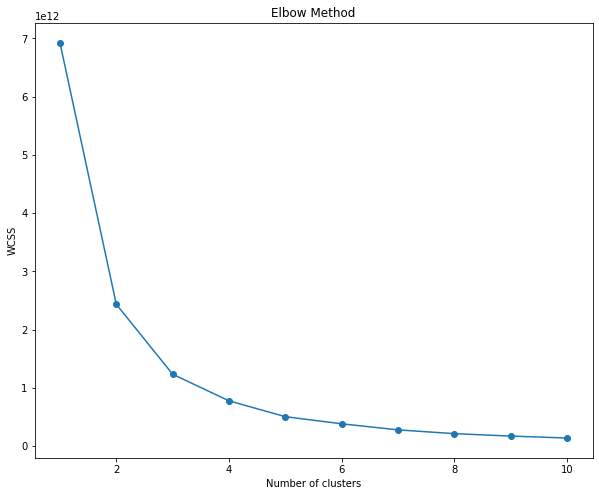

In [68]:
plt.figure(figsize=(10,8))
plt.plot(range(1,11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [69]:
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', n_init=10, max_iter=300, random_state=100)
kmeans.fit(cluster_data)
cluster_labels=kmeans.fit_predict(X)
cluster_data['Cluster'] = cluster_labels


In [70]:
cluster_data.head()

,TransactionID,Qty,TotalAmount,Cluster
0,17,60,623300,3
1,13,57,392300,1
2,15,56,446200,1
3,10,46,302500,0
4,7,27,268600,2


In [71]:
cluster_data.value_counts('Cluster')

Cluster
0    180
1    114
2     93
3     60
dtype: int64

In [72]:
cluster_summary = cluster_data.groupby('Cluster').agg({'TransactionID': 'mean', 'Qty': 'mean', 'TotalAmount': 'mean'})
print(cluster_summary)


         TransactionID        Qty    TotalAmount
Cluster                                         
0            10.427778  37.350000  325663.333333
1            13.254386  49.078947  436203.508772
2             7.021505  24.505376  208283.870968
3            16.316667  61.650000  572100.000000


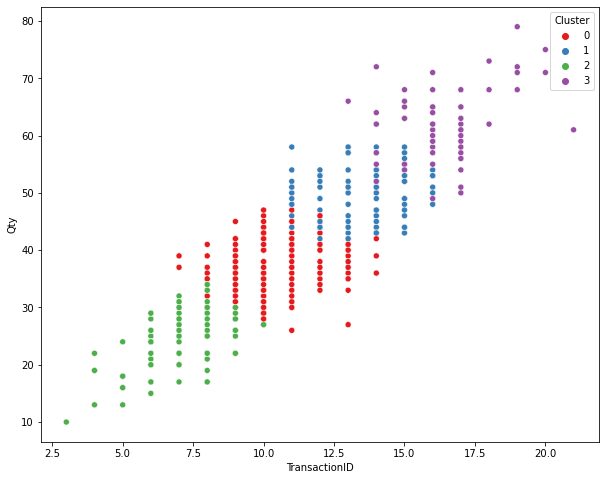

In [73]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=cluster_data, x='TransactionID', y='Qty', hue='Cluster', palette='Set1')
plt.show()

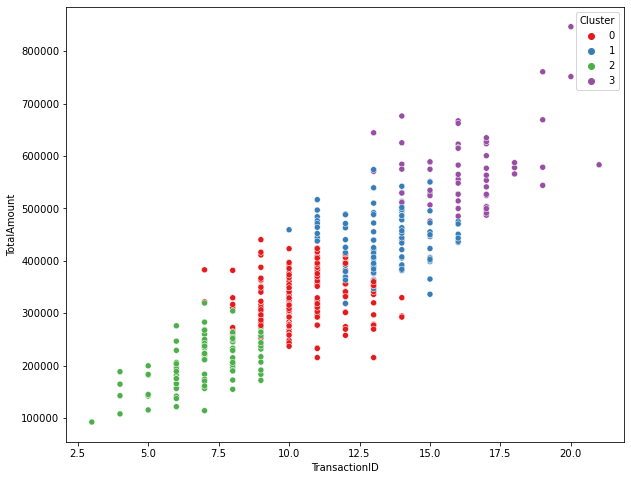

In [74]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=cluster_data, x='TransactionID', y='TotalAmount', hue='Cluster', palette='Set1')
plt.show()

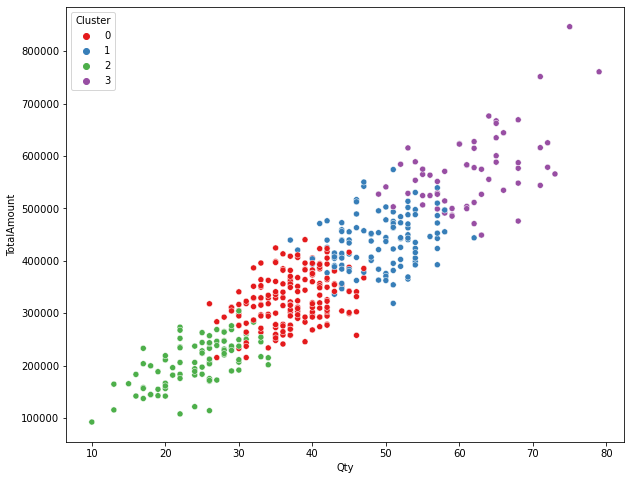

In [75]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=cluster_data, x='Qty', y='TotalAmount', hue='Cluster', palette='Set1')
plt.show()